## XGBOOST

In [1]:
# Data Wrangling
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline


# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectPercentile
from sklearn import model_selection

# Hyperparameter Optimization
import optuna

# Modeling
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Evaluation
from sklearn.metrics import *
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm, tqdm_notebook
import platform
from itertools import combinations
from scipy.stats.mstats import gmean
import gc
import bisect

In [46]:
panel = pd.read_csv(os.path.abspath("../input")+'/panel.csv')
survey = pd.read_csv(os.path.abspath("../input")+'/survey.csv')
response_train = pd.read_csv(os.path.abspath("../input")+'/response_train.csv')
response_test = pd.read_csv(os.path.abspath("../input")+'/response_test.csv')

In [47]:
# panel조사 분류별 응답율 피처 생성
SQ = ['SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6', 'SQ7', 'SQ8'] # 개인정보
A = ['A1'] # 신규구입/렌트 가전
B = ['B1', 'B2', 'B3', 'B4', 'B5'] # 통신
C = ['C1', 'C2', 'C3'] # 보험/금융
D = ['DQ1', 'DQ2', 'DQ3', 'DQ4', 'DQ5', 'DQ6', 'DQ7'] # 직업
F = ['F1', 'F2'] # 이용마트
H = ['H1'] # 음용주류
T = ['T1'] # 담배
X = ['X1', 'X2', 'X3', 'X4'] # 자동차

# 결측치가 아닌 값의 비율
panel['SQ_R'] = 1 - panel[SQ].isnull().mean(axis=1)
panel['A_R'] = 1 - panel[A].isnull().mean(axis=1)
panel['B_R'] = 1 - panel[B].isnull().mean(axis=1)
panel['C_R'] = 1 - panel[C].isnull().mean(axis=1)
panel['D_R'] = 1 - panel[D].isnull().mean(axis=1)
panel['F_R'] = 1 - panel[F].isnull().mean(axis=1)
panel['H_R'] = 1 - panel[H].isnull().mean(axis=1)
panel['T_R'] = 1 - panel[T].isnull().mean(axis=1)
panel['X_R'] = 1 - panel[X].isnull().mean(axis=1)
# panel 조사 전체 응답율
panel['ALL_R'] = 1 - panel[SQ+A+B+C+D+F+H+T+X].isnull().mean(axis=1)

In [48]:
# # 대상지역 생성, TITLE에 해외 단어 포함되어있으면 해외 아니면 기타
survey['대상지역'] = np.where(survey['TITLE'].str.contains('해외'), '해외', '기타')
# # 대상자유형
survey['대상자유형'] = '기타'
survey['대상자유형'] = np.where(survey['TITLE'].str.contains('일반인'), '일반인', survey['대상자유형'])
survey['대상자유형'] = np.where(survey['TITLE'].str.contains('소비자'), '소비자', survey['대상자유형'])

In [49]:
# train, test데이터 셋
train = response_train.merge(panel).merge(survey)
test = response_test.merge(panel).merge(survey).sort_values(by='ID')

In [50]:
del panel, survey, response_train, response_test
gc.collect()

5439

In [11]:
print(train.columns)
print(train.shape)

Index(['userID', 'surveyID', 'TIME', 'STATUS', 'BIRTH', 'GENDER', 'REGION',
       'TYPE', 'SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6', 'SQ7', 'SQ8', 'A1',
       'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'F1', 'F2', 'H1', 'T1',
       'X1', 'X2', 'X3', 'X4', 'DQ1', 'DQ2', 'DQ3', 'DQ4', 'DQ5', 'DQ6', 'DQ7',
       'SQ_R', 'A_R', 'B_R', 'C_R', 'D_R', 'F_R', 'H_R', 'T_R', 'X_R', 'ALL_R',
       'TITLE', 'IR', 'LOI', 'CATEGORIES', 'CPI', '대상지역', '대상자유형'],
      dtype='object')
(4904549, 57)


- SQ1 ~ DQ7: 패널 가입 시 설문조사 데이터
- IR: 설문 응답 가능성 최대값 100
- LOI: 설문하는데 걸리는 시간(분)
- CPI: 패널 응답 리워드 포인트

In [12]:
# 결측치 비율
for i in train.columns:
    print(i,'\t', train[i].isnull().sum()/train.shape[0])

userID 	 0.0
surveyID 	 0.0
TIME 	 0.0
STATUS 	 0.0
BIRTH 	 5.219644048820799e-05
GENDER 	 5.219644048820799e-05
REGION 	 0.000293808870091827
TYPE 	 0.0
SQ1 	 0.0012832984235655511
SQ2 	 0.0019506380709011166
SQ3 	 0.11090948423596135
SQ4 	 0.11132257012826256
SQ5 	 0.17909251187010264
SQ6 	 0.17948785912833168
SQ7 	 0.22174006213415343
SQ8 	 0.22244919971234867
A1 	 0.2513170935798582
B1 	 0.2574271355021634
B2 	 0.28851643647560665
B3 	 0.2945434942132294
B4 	 0.30725332747210804
B5 	 0.31235756845328694
C1 	 0.3676189186814119
C2 	 0.4768152994291626
C3 	 0.4900189599492227
F1 	 0.5184415529338171
F2 	 0.5308465671359385
H1 	 0.5505268680157951
T1 	 0.5577016357671215
X1 	 0.5768157276030885
X2 	 0.585550475691037
X3 	 0.6033249948160371
X4 	 0.6351536094348329
DQ1 	 0.6571886630146829
DQ2 	 0.6632379450179823
DQ3 	 0.6718214049854533
DQ4 	 0.6740004024834904
DQ5 	 0.6802221774112156
DQ6 	 0.6811341878733397
DQ7 	 0.6852760569830172
SQ_R 	 0.0
A_R 	 0.0
B_R 	 0.0
C_R 	 0.0
D_R 	 0.

In [52]:
train.TIME = train.TIME.astype('datetime64[s]')
test.TIME = test.TIME.astype('datetime64[s]')

In [53]:
train['TIME_hour'] = train.TIME.dt.hour
train['TIME_min'] = train.TIME.dt.minute
train['dayofweek'] = train.TIME.dt.dayofweek

test['TIME_hour'] = test.TIME.dt.hour
test['TIME_min'] = test.TIME.dt.minute
test['dayofweek'] = test.TIME.dt.dayofweek

In [54]:
y_train = train['STATUS']
test_id = test.ID
# 쓸모 없는 칼럼 삭제 
X_train = train.drop(['userID','surveyID','TIME','STATUS',
                      'SQ1','SQ2','SQ3', 'DQ5', 'DQ6', 'DQ7'], axis = 1)
X_test = test.drop(['userID','ID','surveyID','TIME',
                    'SQ1','SQ2','SQ3', 'DQ5', 'DQ6', 'DQ7'], axis = 1)

In [55]:
del train, test 
gc.collect()

47

In [17]:
X_train.columns

Index(['BIRTH', 'GENDER', 'REGION', 'TYPE', 'SQ4', 'SQ5', 'SQ6', 'SQ7', 'SQ8',
       'A1', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'F1', 'F2', 'H1',
       'T1', 'X1', 'X2', 'X3', 'X4', 'DQ1', 'DQ2', 'DQ3', 'DQ4', 'SQ_R', 'A_R',
       'B_R', 'C_R', 'D_R', 'F_R', 'H_R', 'T_R', 'X_R', 'ALL_R', 'TITLE', 'IR',
       'LOI', 'CATEGORIES', 'CPI', '대상지역', '대상자유형', 'TIME_hour', 'TIME_min',
       'dayofweek'],
      dtype='object')

In [56]:
num_features = ['BIRTH','IR','LOI','CPI','TIME_hour','TIME_min']
cat_features = list(set(X_train.columns) - set(num_features))

In [57]:
# 대부분의 값 결측치 0으로 채움
na_0 = ['SQ4', 'SQ5', 'SQ6', 'SQ7', 'SQ8',
       'A1', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'F1', 'F2', 'H1',
       'T1', 'X1', 'X2', 'X3', 'X4', 'DQ1', 'DQ2', 'DQ3', 'DQ4','CATEGORIES']

In [58]:
for i in na_0:
    X_train[i]=X_train[i].fillna(0)

In [59]:
for i in na_0:
    X_test[i]=X_test[i].fillna(0)

In [60]:
num_na = ['BIRTH']
cat_na = ['GENDER', 'REGION']

In [61]:
# 결측치 비율 낮은 칼럼들은 평균값이나 최빈값으로 채움
from sklearn.impute import SimpleImputer 

if len(num_na) > 0:
    imp = SimpleImputer(strategy='mean')
    X_train[num_na] = imp.fit_transform(X_train[num_na])
    X_test[num_na] = imp.transform(X_test[num_na])
if len(cat_na) > 0:  
    imp = SimpleImputer(strategy="most_frequent")
    X_train[cat_na] = imp.fit_transform(X_train[cat_na])
    X_test[cat_na] = imp.transform(X_test[cat_na])

In [62]:
X_train.GENDER=X_train.GENDER.astype('int') 
X_train.BIRTH=X_train.BIRTH.astype('int') 
X_train.REGION=X_train.REGION.astype('int') 
X_train.IR=X_train.IR.astype('int') 
X_train.LOI=X_train.LOI.astype('int') 
X_train.CPI=X_train.CPI.astype('int') 

In [63]:
X_test.GENDER=X_test.GENDER.astype('int') 
X_test.BIRTH=X_test.BIRTH.astype('int') 
X_test.REGION=X_test.REGION.astype('int') 
X_test.IR=X_test.IR.astype('int') 
X_test.LOI=X_test.LOI.astype('int') 
X_test.CPI=X_test.CPI.astype('int') 

In [64]:
# LabelEncoder
encoders = {}

for feature in tqdm(cat_features, desc="Encoding features"):
    le = LabelEncoder()
    X_train[feature] = le.fit_transform(X_train[feature].astype(str))
    le_classes_set = set(le.classes_)
    X_test[feature] = X_test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    X_test[feature] = le.transform(X_test[feature].astype(str))
    encoders[feature] = le

Encoding features: 100%|██████████| 44/44 [00:54<00:00,  1.24s/it]


[LightGBM] [Info] Number of positive: 1658035, number of negative: 3246514
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.293948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4291
[LightGBM] [Info] Number of data points in the train set: 4904549, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.338061 -> initscore=-0.671949
[LightGBM] [Info] Start training from score -0.671949


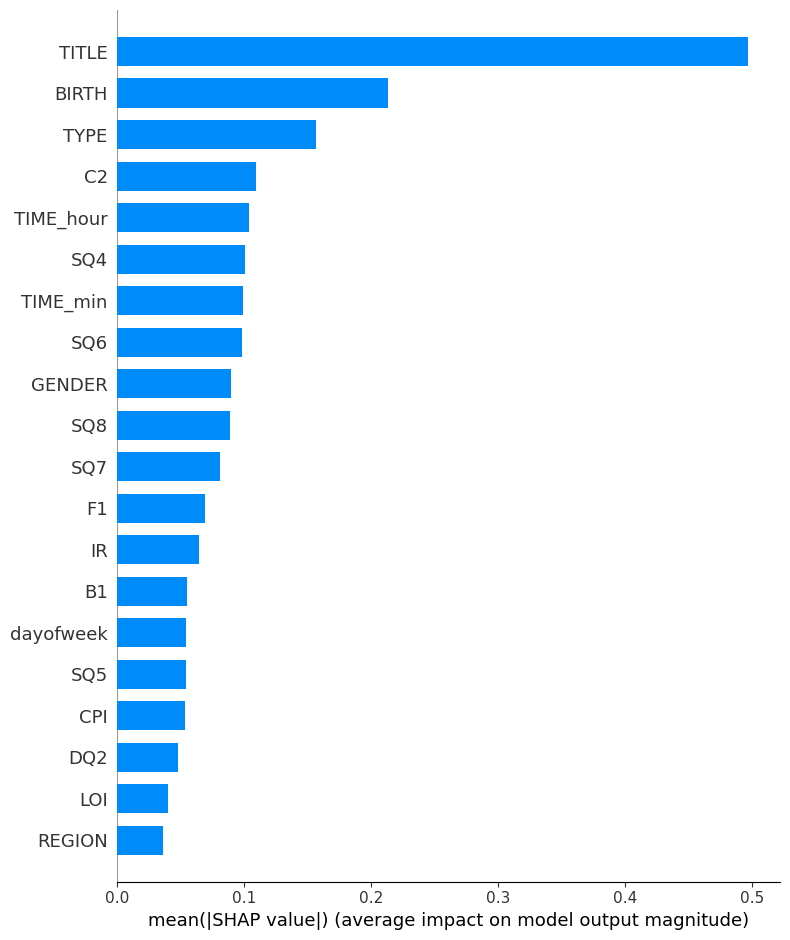

,column_name,shap_importance
40,TITLE,0.497029
0,BIRTH,0.213442
3,TYPE,0.156119
16,C2,0.109505
47,TIME_hour,0.103823
4,SQ4,0.100665
48,TIME_min,0.098672
6,SQ6,0.098054
1,GENDER,0.089179
8,SQ8,0.088764


In [41]:
# Method: Using SHAP values
import shap

# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
model = LGBMClassifier(random_state=0).fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')


feature_names = X_importance.columns.tolist()
## 변수 중요도
a = []
b = []
for i in range(X_importance.shape[1]):
    feature_imp = np.mean(np.abs(shap_values[:, i]))
    a.append(feature_names[i])
    b.append(feature_imp)

importance_df = pd.DataFrame([a, b]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

In [42]:
# feature 중요도가 0 이상만 선택하기
features_selected = importance_df.query('shap_importance > 0').column_name.tolist()
X_train = X_train[features_selected]
X_test = X_test[features_selected]
print(X_train.shape)

(4904549, 41)


In [68]:
train_X, valid_X, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [70]:
# 하이퍼 파라미터 튜닝
def objective_xgbm(trial, X, y):
    
    param_bo = {
        'n_estimators': trial.suggest_int("n_estimators", 80, 350),
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3, step=0.05),
        'max_depth': trial.suggest_int("max_depth", 6, 12),
        'subsample': trial.suggest_float("subsample", 0.6, 1, step=0.1),
        'colsample': trial.suggest_float("colsample", 0.6, 1, step=0.1),
    }

    model = XGBClassifier(**param_bo,tree_method='hist', random_state=0) # 데이터가 많아 hist 방식 사용
    # 히스토그램(bin) 단위로 데이터를 압축하여 저장하므로 메모리 사용량이 줄어듦.
    score = model_selection.cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring='roc_auc')
    return score.mean()

study_xgbm = optuna.create_study(direction="maximize")
study_xgbm.optimize(lambda trial: objective_xgbm(trial, train_X, train_y), n_trials=72)

[I 2025-02-04 22:00:18,842] A new study created in memory with name: no-name-4ed42d04-9e10-4309-91df-aa3653cb49e4
[I 2025-02-04 22:01:55,105] Trial 0 finished with value: 0.8720565370309098 and parameters: {'n_estimators': 172, 'learning_rate': 0.01, 'max_depth': 11, 'subsample': 0.8, 'colsample': 0.8}. Best is trial 0 with value: 0.8720565370309098.
[I 2025-02-04 22:03:10,289] Trial 1 finished with value: 0.932273581892199 and parameters: {'n_estimators': 133, 'learning_rate': 0.16000000000000003, 'max_depth': 12, 'subsample': 0.9, 'colsample': 0.6}. Best is trial 1 with value: 0.932273581892199.
[I 2025-02-04 22:03:54,172] Trial 2 finished with value: 0.9063943760594466 and parameters: {'n_estimators': 106, 'learning_rate': 0.11, 'max_depth': 9, 'subsample': 0.6, 'colsample': 1.0}. Best is trial 1 with value: 0.932273581892199.
[I 2025-02-04 22:05:06,983] Trial 3 finished with value: 0.8534243195787766 and parameters: {'n_estimators': 163, 'learning_rate': 0.01, 'max_depth': 9, 'subs

[I 2025-02-04 23:02:55,815] Trial 33 finished with value: 0.9342623723705461 and parameters: {'n_estimators': 286, 'learning_rate': 0.16000000000000003, 'max_depth': 12, 'subsample': 0.8, 'colsample': 0.7}. Best is trial 11 with value: 0.9357969557605348.
[I 2025-02-04 23:05:09,849] Trial 34 finished with value: 0.9338058268072947 and parameters: {'n_estimators': 331, 'learning_rate': 0.11, 'max_depth': 11, 'subsample': 1.0, 'colsample': 0.8}. Best is trial 11 with value: 0.9357969557605348.
[I 2025-02-04 23:07:18,935] Trial 35 finished with value: 0.9348320024159076 and parameters: {'n_estimators': 239, 'learning_rate': 0.16000000000000003, 'max_depth': 12, 'subsample': 0.9, 'colsample': 0.6}. Best is trial 11 with value: 0.9357969557605348.
[I 2025-02-04 23:09:50,744] Trial 36 finished with value: 0.9286705598474508 and parameters: {'n_estimators': 309, 'learning_rate': 0.060000000000000005, 'max_depth': 11, 'subsample': 0.7, 'colsample': 0.8}. Best is trial 11 with value: 0.93579695

[I 2025-02-05 00:24:30,573] Trial 66 finished with value: 0.9358156266507228 and parameters: {'n_estimators': 292, 'learning_rate': 0.16000000000000003, 'max_depth': 12, 'subsample': 1.0, 'colsample': 0.7}. Best is trial 63 with value: 0.9358978493436705.
[I 2025-02-05 00:26:29,767] Trial 67 finished with value: 0.9344399679505999 and parameters: {'n_estimators': 292, 'learning_rate': 0.16000000000000003, 'max_depth': 11, 'subsample': 1.0, 'colsample': 0.7}. Best is trial 63 with value: 0.9358978493436705.
[I 2025-02-05 00:28:12,302] Trial 68 finished with value: 0.9329461902007447 and parameters: {'n_estimators': 306, 'learning_rate': 0.21000000000000002, 'max_depth': 10, 'subsample': 1.0, 'colsample': 0.7}. Best is trial 63 with value: 0.9358978493436705.
[I 2025-02-05 00:29:49,077] Trial 69 finished with value: 0.934644028850369 and parameters: {'n_estimators': 191, 'learning_rate': 0.16000000000000003, 'max_depth': 12, 'subsample': 1.0, 'colsample': 0.7}. Best is trial 63 with valu

In [71]:
study_xgbm.best_params

{'n_estimators': 328,
 'learning_rate': 0.16000000000000003,
 'max_depth': 12,
 'subsample': 1.0,
 'colsample': 0.7}

In [72]:
a = XGBClassifier(tree_method='hist',n_estimators= 328,learning_rate= 0.16,
                  max_depth= 12,subsample= 1.0,colsample= 0.7, random_state=0)
a.fit(train_X, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None, colsample=0.7,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.16, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=328, n_jobs=None,
              num_parallel_tree=None, ...)

In [73]:
pred = a.predict(valid_X)
pred_proba = a.predict_proba(valid_X)[:,1]

In [74]:
from sklearn.metrics import *

In [79]:
accuracy = accuracy_score(valid_y, pred) 
precision = precision_score(valid_y, pred) 
recall = recall_score(valid_y, pred) 
f1 = f1_score(valid_y, pred) 
# ROC AUC 
roc_auc = roc_auc_score(valid_y, pred_proba) 

print(f'accuracy: {accuracy}, precision: {precision}, recall: {recall}, f1: {f1}, roc_auc: {roc_auc}')

accuracy: 0.8634272667268343, precision: 0.8257788790202903, recall: 0.815163979499813, f1: 0.8204370965313875, roc_auc: 0.9380694763637805


In [50]:
t = pd.Timestamp.now()
fname = f"xgboost_submission_{t.month:02}{t.day:02}_{t.hour:02}{t.minute:02}.csv"
pd.DataFrame({'ID': test_id, 'STATUS': a.predict_proba(X_test)[:,1]}).to_csv(fname, index=False)
print(f"'{fname}' is ready to submit.")

'xgboost_submission_1214_1746.csv' is ready to submit.


In [ ]:
del X_train,X_test
gc.collect()

## 앙상블(0.90137)

In [ ]:
c01 = pd.read_csv(os.path.abspath("../input")+'/xgboost0.89661.csv')
c02 = pd.read_csv(os.path.abspath("../input")+'/dnn_0.89418.csv')

In [ ]:
sub = pd.read_csv("../input")+'/sample_submission.csv')

In [ ]:
b = c01.copy()

In [ ]:
b.STATUS=0.5*c01.STATUS + 0.5*c02.STATUS

In [ ]:
sub.STATUS=b.STATUS

In [ ]:
sub.to_csv('0.90137.csv', index=False)